# NIPS 2017 Figure 1

In [1]:
%run -i NIPS2017.ipynb

# FIGURE and GRID
FIG_HEIGHT_MM = 50
FIG_WIDTH_MM = FIG_WIDTH_MM  # set in NIPS2017 notebook to a default value for all figures
FIG_N_ROWS = 1
ROW_1_NCOLS = 3
ROW_1_HEIGHT_MM = FIG_HEIGHT_MM
ROW_1_WIDTH_COL_1_MM = FIG_WIDTH_MM / ROW_1_NCOLS
ROW_1_WIDTH_COL_2_MM = FIG_WIDTH_MM / ROW_1_NCOLS
ROW_1_WIDTH_COL_3_MM = FIG_WIDTH_MM / ROW_1_NCOLS

# PATHS
PANEL_A = PATH_DROPBOX_FIGS + 'fig1_a.svg'
PANEL_B = PATH_DROPBOX_FIGS + 'fig1_b.svg'
PANEL_C = PATH_DROPBOX_FIGS + 'fig1_c.svg'

## Panel a

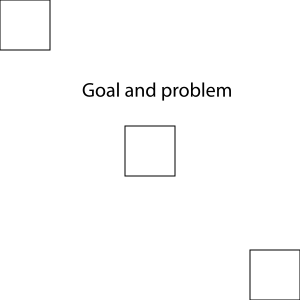

In [2]:
try:
    svg(PANEL_A)
except:
    pass

Panel a is drawn in Illustrator, and export as a `svg`.

Above we defined that row 1 col 1 has the following dimensions in mm:

In [3]:
print('width : {:g}mm'.format(ROW_1_WIDTH_COL_1_MM))
print('height : {:g}mm'.format(ROW_1_HEIGHT_MM))

width : 53.3333mm
height : 50mm


In Illustrator, it is advisable to work in units of `px`, however.

Panel a should have the following dimensions in pixels when working with illustrator/inkscape:

In [4]:
print('width : {:g}px'.format(mm2px(ROW_1_WIDTH_COL_1_MM)))
print('height : {:g}px'.format(mm2px(ROW_1_HEIGHT_MM)))

width : 320px
height : 300px


Note: It's good to keep an `.ai` file for illustrator figures along, because fonts are only exported properly when `convert to outline` is choosen in the export dialog. However, we want to have them as texts as well, which is the reason for keeping an `.ai` file. 

## Panel B

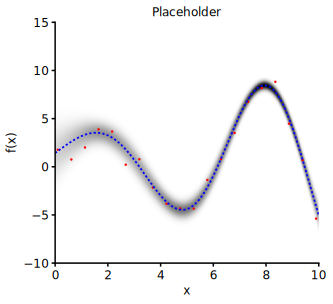

In [5]:
try:
    svg(PANEL_B)
except:
    pass

Panel b will illustrate theta space, x space, the kernel, and possibly the importance weights.

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/site-packages/matplotlib-2.0.0-py3.6-macosx-10.12-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


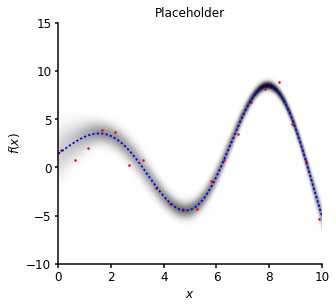

In [94]:
# no need toexecute unless you want regenerate panel_b

"""
http://nbviewer.jupyter.org/gist/kjordahl/3947841/bootstrap.ipynb
http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
"""

from scipy import ndimage
from sklearn.gaussian_process import GaussianProcess

def pdense(x, y, sigma, M=1000):
    """ Plot probability density of y with known stddev sigma
    """
    assert len(x) == len(y) and len(x) == len(sigma)
    N = len(x)
    # TODO: better y ranging
    ymin, ymax = min(y - 2 * sigma), max(y + 2 * sigma)
    yy = np.linspace(ymin, ymax, M)
    a = [np.exp(-((Y - yy) / s) ** 2) / s for Y, s in zip(y, sigma)]
    A = np.array(a)
    A = A.reshape(N, M)
    plt.imshow(-A.T, cmap='gray', aspect='auto',
               origin='lower', extent=(min(x)[0], max(x)[0], ymin, ymax))
    plt.title('Placeholder')


def gpr(seed=0, N=20, M=1000, sigma=1.0):
    """ from scikits.learn demo
    """
    np.random.seed(seed)

    def f(x):
        """The function to predict."""
        return x * np.sin(x)

    X = np.linspace(0.1, 9.9, 20)
    X = np.atleast_2d(X).T
    y = f(X).ravel()
    y = np.random.normal(y, sigma)
    x = np.atleast_2d(np.linspace(0, 10, M)).T
    nugget = (sigma / y) ** 2
    gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                         thetaL=1e-1, thetaU=1.0,
                         nugget=nugget,
                         random_start=100)
    gp.fit(X, y)
    y2, MSE = gp.predict(x, eval_MSE=True)
    s2 = np.sqrt(MSE)
    return X, y, x, y2, s2

X, y, x, y2, s2 = gpr(seed=0)

# matplotlib takes figsize specified as inches
# the most important thing here is, to get the aspect ratio right
fig_inches = (SCALE_IN*mm2inches(ROW_1_WIDTH_COL_2_MM), SCALE_IN*mm2inches(ROW_1_HEIGHT_MM))
plt.figure(figsize=fig_inches)

pdense(x, y2, s2, M=1000)
plt.plot(X, y, 'r.')
plt.plot(x, y2, 'b:')
a = plt.gca()
a.set_ylim(-10, 15)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.savefig(panel_b)  # the figure is saved as svg

Checking the dimensions of the resulting file:

In [95]:
panel = st.fromfile(PANEL_B)
width, height = panel.get_size()
print('size of svg : {}'.format((width, height)))
print('aspect ratio : {}'.format(get_num(width) / get_num(height)))
print('desired ratio : {}'.format(ROW_1_WIDTH_COL_2_MM / ROW_1_HEIGHT_MM))

size of svg : ('333pt', '304pt')
aspect ratio : 1.0953947368421053
desired ratio : 1.0666666666666667


In [96]:
#!python svg-resize.py $panel_b --width $fig_width_cm_str --height $fig_height_cm_str

## Panel C

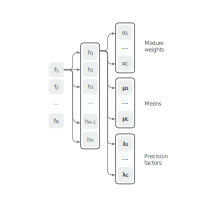

In [97]:
try:
    svg(PANEL_C)
except:
    pass

## Put together figure

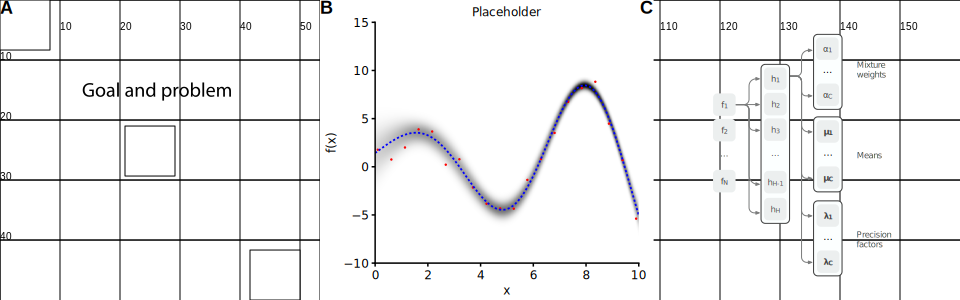

In [101]:
panel_a = PATH_DROPBOX_FIGS + 'fig1_a_illustrator.svg'

fig = create_fig(FIG_WIDTH_MM, FIG_HEIGHT_MM)
if True:  # set to False to disable grid
    fig = add_grid(fig, 10, 10)
    fig = add_grid(fig, 160/3, 10, font_size_px=0.0001)
fig = add_svg(fig, PANEL_A, 0, 0)
fig = add_svg(fig, PANEL_B, ROW_1_WIDTH_COL_1_MM, 0)
fig = add_svg(fig, PANEL_C, ROW_1_WIDTH_COL_1_MM + ROW_1_WIDTH_COL_2_MM, 0, scale=1.5)

fig = add_label(fig, 'A', 0*160/3, 2.3)
fig = add_label(fig, 'B', 1*160/3, 2.3)
fig = add_label(fig, 'C', 2*160/3, 2.3)

PATH_SVG = PATH_DROPBOX_FIGS + 'fig1.svg'
fig.save(PATH_SVG)

svg(PATH_SVG)

!$INKSCAPE --export-pdf $PATH_DROPBOX_FIGS/fig1.pdf $PATH_SVG